MAE: 4.4008
RMSE: 8.7825
R²: 0.2610


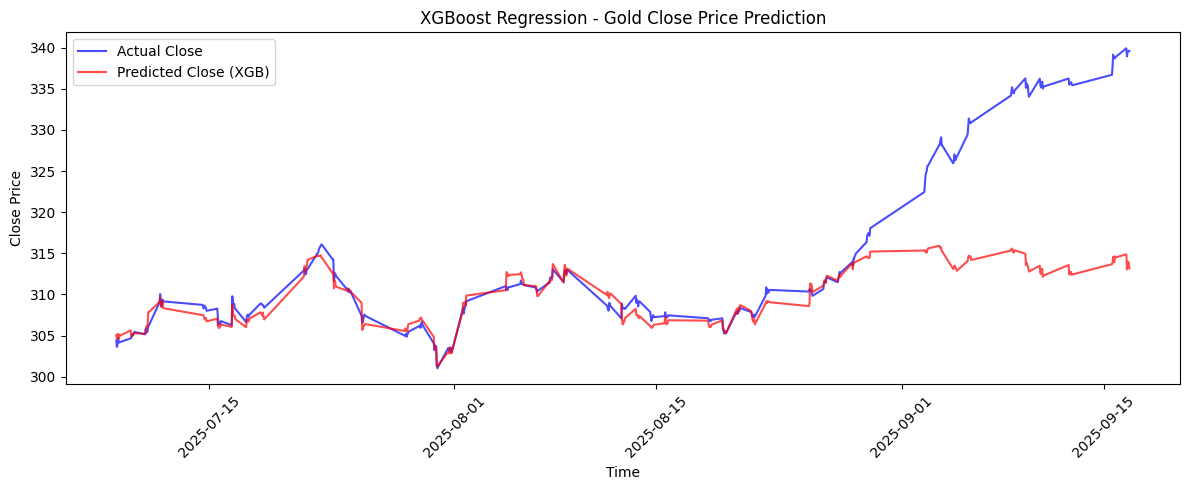

C:\Users\User\AppData\Local\Temp\ipykernel_7136\403222265.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


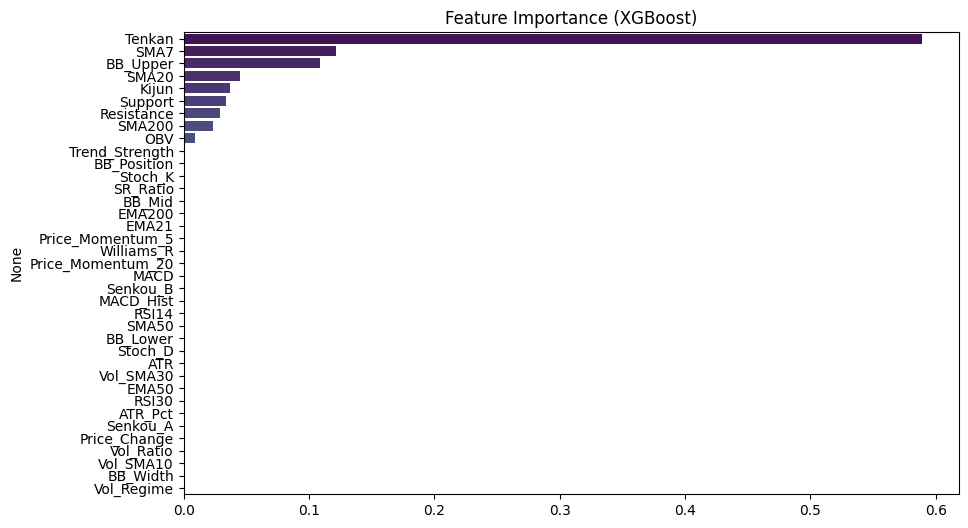

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

# 1. Load dataset
df = pd.read_csv("../dataset.csv", parse_dates=["Datetime"])

# 2. Drop NaN values
df = df.dropna()

# 3. Features & Target
X = df.drop(columns=["Datetime", "Close"])  # features (all indicators)
y = df["Close"]                             # target

# 4. Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 5. Train-test split (no shuffle, time series)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

# 6. Train XGBoost Regressor
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# 7. Predictions
y_pred = model.predict(X_test)

# 8. Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# 9. Plot actual vs predicted Close price
plt.figure(figsize=(12,5))
time_index = df["Datetime"].iloc[-len(y_test):]

plt.plot(time_index, y_test.values, label="Actual Close", color="blue", alpha=0.7)
plt.plot(time_index, y_pred, label="Predicted Close (XGB)", color="red", alpha=0.7)

plt.legend()
plt.title("XGBoost Regression - Gold Close Price Prediction")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 10. Feature importance plot
plt.figure(figsize=(10,6))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.title("Feature Importance (XGBoost)")
plt.show()


In [3]:
import joblib

joblib.dump(model, 'regression_model.pkl')
joblib.dump(scaler, 'regression_scaler.pkl')

['regression_scaler.pkl']